remember to create a virtual environment and install the requirements:

```
python3 -m venv .venv
source .venv/bin/activate
pip install -r reqs.txt
```

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import pennylane as qml

import time
import matplotlib.pyplot as plt

from aux import *

# Introduction to JAX

In short, JAX is an array-oriented numerical computing library that enables composable transformations. These include just-in-time (JIT) compilation, automatic vectorization and automatic differentiation. On top of that, since it leverages the XLA (Accelerated Linear Algebra)
compiler it can run on CPUs, GPUs and TPUs natively.

In [2]:
# Check available devices
print("JAX devices:", jax.devices())

def compute(x):
    return jnp.dot(x, x.T) + jnp.sum(x)

x = jnp.ones((3, 3))

# Run on CPU
cpu_result = jax.jit(compute, backend="cpu")(x)
print("Result on CPU:", cpu_result)

# Run on GPU (if available)
if any(d.device_kind == "GPU" for d in jax.devices()):
    gpu_result = jax.jit(compute, backend="gpu")(x)
    print("Result on GPU:", gpu_result)

# Run on TPU (if available)
if any(d.device_kind == "TPU" for d in jax.devices()):
    tpu_result = jax.jit(compute, backend="tpu")(x)
    print("Result on TPU:", tpu_result)

JAX devices: [CpuDevice(id=0)]
Result on CPU: [[12. 12. 12.]
 [12. 12. 12.]
 [12. 12. 12.]]


JAX provides an array interface that mimics NumPy and can be used as a drop-in replacement for NumPy arrays. The most notable difference between `numpy`, usually referred as `np`, arrays and `jax.numpy`, usually referred as `jnp`, is that the latter are always immutable.

In [3]:
# Create a NumPy array
np_array = np.array([1, 2, 3])
print("Original NumPy array:", np_array)
np_array[0] = 10  # Mutating a NumPy array is allowed
print("Modified NumPy array:", np_array)

# Create a JAX array
jnp_array = jnp.array([1, 2, 3])

try:
    jnp_array[0] = 10  # Attempting to mutate a JAX array
except TypeError as e:
    print("\n[!] JAX array mutation error:", e)

# Instead of mutating, we create a new array
new_jnp_array = jnp_array.at[0].set(10)
print("\nOriginal JAX array:", jnp_array)
print("New JAX array after modification:", new_jnp_array)


Original NumPy array: [1 2 3]
Modified NumPy array: [10  2  3]

[!] JAX array mutation error: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

Original JAX array: [1 2 3]
New JAX array after modification: [10  2  3]


All JAX operations are implemented in terms of XLA. This means that whenever we use `jnp` we will be taking advantage of the accelerated linear algebra compiler. However, we also have a lower level API available with `jax.lax`, which contains wrappers for primitive XLA operations. All `jnp` operations are implemented in terms of `jax.lax`.

JAX has an internal representation of programs called jaxpr language. We can use the `jax.make_jaxpr` function to obtain the jaxpr representation of a function. This can be useful for finding out how certain functions get transformed to lower level operations. For instance, we can see how `jnp.dot` translates to a more general `jax.lax.dot_general`. 


In [4]:
def high_level(x, y):
    return jnp.dot(x, y)

def low_level(x, y):
    return jax.lax.dot_general(
        x, y,
        dimension_numbers=(((1,), (0,)), ((), ()))  # Batch dimensions are empty
    )
    
A = jnp.array([[1, 2], [3, 4]])
B = jnp.array([[5, 6], [7, 8]])
jaxpr_high_level = jax.make_jaxpr(high_level)(A, B)
jaxpr_low_level = jax.make_jaxpr(low_level)(A, B)

print("JAXpr for jnp.dot:\n", jaxpr_high_level, "\n")
print("JAXpr for jax.lax.dot_general:\n", jaxpr_low_level)

JAXpr for jnp.dot:
 { lambda ; a:i32[2,2] b:i32[2,2]. let
    c:i32[2,2] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=int32
    ] a b
  in (c,) } 

JAXpr for jax.lax.dot_general:
 { lambda ; a:i32[2,2] b:i32[2,2]. let
    c:i32[2,2] = dot_general[dimension_numbers=(([1], [0]), ([], []))] a b
  in (c,) }


Along with a NumPy-like API of functions that operate on arrays, JAX also includes a number of composable transformations which operate on functions. The ones we are interested the most in are:
- `jax.jit`.
- `jax.vmap`.
- `jax.grad`.

To do transformations, JAX uses the concept of tracing a function. Tracing works by replacing the array inputs of a function by abstract placeholders with the same shape and type. This allows JAX to determine the sequence of operations of a function and the effect these have on the input arrays, independently of their content.

We can see how JAX sees traced arrays by printing inside a function subject to a transform:

In [5]:
@jax.jit
def f(x, a):
  y = jnp.arange(5)
  z = 5
  print("inside the function we see x as", x)
  print("inside the function we see y as", y)
  print("inside the function we see z as", z)
  print("inside the function we see a as", a)
  
  return x + 1

x = jnp.arange(5)
print("outside the function we see x as", x)
result = f(x, 5)
print("f(x, 5) = ", result)

outside the function we see x as [0 1 2 3 4]
inside the function we see x as Traced<ShapedArray(int32[5])>with<DynamicJaxprTrace>
inside the function we see y as Traced<ShapedArray(int32[5])>with<DynamicJaxprTrace>
inside the function we see z as 5
inside the function we see a as Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace>
f(x, 5) =  [1 2 3 4 5]


In the example above, the variable $x$, which is passed as an argument, appears inside the function as `Traced<ShapedArray(int32[5])>`. This indicates that JAX has replaced it with a traced representation that preserves its shape (`[5]`) and type (`int32`), but not its actual values. Similarly, $y$, which is created within the function using `jnp.arange`, is also traced because it is derived from a JAX operation. In contrast, $z$, which is assigned a static integer value, remains a standard Python integer and is not subject to tracing. The variable $a$, another function argument, is traced in the same manner as $x$, but with an additional property: it is weakly typed, meaning that its type can be implicitly upcast, e.g. `int32` to `int64`, depending on how it is used in the computation.

If we don't use any transform, then all those values are concrete:

In [6]:
def f(x, a):
  y = jnp.arange(5)
  z = 5
  print("inside the function we see x as", x)
  print("inside the function we see y as", y)
  print("inside the function we see z as", z)
  print("inside the function we see a as", a)
  
  return x + 1

x = jnp.arange(5)
print("outside the function we see x as", x)
result = f(x, 5)
print("f(x, 5) = ", result)

outside the function we see x as [0 1 2 3 4]
inside the function we see x as [0 1 2 3 4]
inside the function we see y as [0 1 2 3 4]
inside the function we see z as 5
inside the function we see a as 5
f(x, 5) =  [1 2 3 4 5]


## Just-in-Time compilation

By default, JAX executes operations eagerly, dispatching each operation individually to XLA without ahead-of-time compilation. The `jax.jit` transform leverages JAX’s tracing mechanism to capture the flow of entire functions, allowing the XLA compiler to optimize, fuse, and compile sequences of operations into a single efficient execution. 

When using JIT, we exchange a slow first execution for much faster subsequent ones. Therefore, JIT is the most useful when we have expensive numerical functions that we need to run a bunch of times.

Despite being very powerful, JIT compilation still has some limitations. In particular, due the tracing mechanism, it requires that branching operations do not depend on the contents of traced parameters. This implies that the following functions will not work with JIT.

In this case because the value of $n$ will not be known at trace-time:

In [7]:
def g(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

try:
    jax.jit(g)(10, 20)  # Raises an error
except Exception as e:
    print("[!] JAX JIT error:", e)

[!] JAX JIT error: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function g at /var/folders/6q/mzgmvrhn3l76p312t6zn3mxw0000gn/T/ipykernel_2748/870922876.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument n.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError


In this case because the final shape of the output will not be known at trace-time:


In [8]:
def get_negatives(x):
  return x[x < 0]

x = jnp.array(np.random.randn(10))

try:
    jax.jit(get_negatives)(x)  # Raises an error
except Exception as e:
    print("[!] JAX JIT error:", e)

[!] JAX JIT error: Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError


Another way to see this limitation is that branching statements are only allowed in JIT functions if and only if they are based on static attributes, like shape and type.

A simple solution to deal with functions like the previous ones is to separate the statement that comes after the branching in an external function and compile that rather than the whole function:

In [9]:
# While loop conditioned on x and n with a jitted body.

@jax.jit
def loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted(x, n):
  i = 0
  while i < n:
    i = loop_body(i)
  return x + i

x = g_inner_jitted(10, 20)
print(x)

30


Alternatively, if we really need to compile the whole function we can mark certain arguments as static. This will make the compiled version of the function depend on the static arguments: 

In [10]:
from functools import partial

@partial(jax.jit, static_argnames=['n'])
def g_jit_decorated(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

x = g_jit_decorated(10, 20)
print(x)

30


This will make it so JAX has to re-compile the function for every new static input. Therefore, it is only a good strategy if we know that there is only a limited number cases.

Subsequent calls of JIT compiled functions use the cached code, which they find via the hash of the function. This implies that we have to be a bit careful when applying the JIT transformation. In some cases, by mistake, we may redefine an equivalent function in a way that modifies its hash and makes it impossible for JIT to use the cached compiled code. Here is an example:

In [11]:
from functools import partial

def unjitted_loop_body(prev_i):
  return prev_i + 1

def g_inner_jitted_partial(x, n):
  i = 0
  while i < n:
    # Don't do this! each time the partial returns
    # a function with different hash
    i = jax.jit(partial(unjitted_loop_body))(i)
  return x + i

def g_inner_jitted_lambda(x, n):
  i = 0
  while i < n:
    # Don't do this!, lambda will also return
    # a function with a different hash
    i = jax.jit(lambda x: unjitted_loop_body(x))(i)
  return x + i

def g_inner_jitted_normal(x, n):
  i = 0
  while i < n:
    # this is OK, since JAX can find the
    # cached, compiled function
    i = jax.jit(unjitted_loop_body)(i)
  return x + i

In [12]:
%timeit g_inner_jitted_partial(10, 20).block_until_ready()
%timeit g_inner_jitted_lambda(10, 20).block_until_ready()
%timeit g_inner_jitted_normal(10, 20).block_until_ready()

228 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
242 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
625 μs ± 20.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


As we can see in the time per loop, the first two are much slower due the fact of not being able to take advantage of the cached code.


## Automatic vectorization

The automatic vectorization transform allows us to extend a function defined on single inputs to support batch operations, while leveraging hardware acceleration whenever possible.
Automatic vectorization allows us to extend a function defined on single input to support batch operations, while capitalizing on hardware acceleration.

To use the `jax.vmap` we just have to specify how to vectorize the function with the `in_axes` and `out_axes` parameters.

The `in_axes` parameter specifies along which axes we vectorize each input. In this case we specify to vectorize along the rows, $0$, for the first two parameters and to not vectorize along the third parameter:

In [13]:
def weighted_array_sum(scale: float, weights: jnp.ndarray, epsilon: float):
    return scale * jnp.sum(weights) + epsilon
    
scales = jnp.array([0.5, 1.0, 1.5]) 
weights = jnp.array([
    [1.0, 0.2, 0.3],
    [0.5, 0.8, 1.0],
    [0.7, 0.1, 0.4]
])
epsilon = 1e-4

vectorized_weighted_array_sum = jax.vmap(weighted_array_sum, in_axes=(0, 0, None))

vectorized_weighted_array_sum(scales, weights, epsilon)

Array([0.7501   , 2.3000998, 1.8001001], dtype=float32)

The `out_axes` parameter specifies how to store the batched results. In this case we show the difference of storing the batched results as rows or as columns:

In [14]:
def identity(x):
    return x

print("id_rows(x) = \n", jax.vmap(identity, in_axes=0, out_axes=0)(weights), "\n")
print("id_cols(x) = \n", jax.vmap(identity, in_axes=0, out_axes=1)(weights))

id_rows(x) = 
 [[1.  0.2 0.3]
 [0.5 0.8 1. ]
 [0.7 0.1 0.4]] 

id_cols(x) = 
 [[1.  0.5 0.7]
 [0.2 0.8 0.1]
 [0.3 1.  0.4]]


All JAX transformations are composable, this means that we can combine `jax.jit` and `jax.vmap` to create just-in-time compiled-vectorized  functions. It's important to note that these two transformations commute, it doesn't matter if we compile or vectorize first, it will always create a compiled version of the vectorized function rather than a vectorized version of compiled functions.


## Automatic differentiation

The automatic differentiation transform, `jax.grad`, allows us to get the gradient of any function.  We can apply it multiple times to obtain a higher order gradient. Also we can choose along which parameters to compute it.

In [15]:
def func(x, y):
    return x**2 + y**3

grad_x = jax.grad(func, argnums=0)        # Derivative w.r.t. x
grad_y = jax.grad(func, argnums=1)        # Derivative w.r.t. y
grad   = jax.grad(func, argnums= (0, 1))  # Both

x, y = 2.0, 3.0
print("Gradient w.r.t x:", grad_x(x, y))  # 2*x = 4
print("Gradient w.r.t y:", grad_y(x, y))  # 3*y^2 = 27
print("Gradient both:", grad(x, y))       # (4, 27)

Gradient w.r.t x: 4.0
Gradient w.r.t y: 27.0
Gradient both: (Array(4., dtype=float32, weak_type=True), Array(27., dtype=float32, weak_type=True))


In [16]:
def loss_fn(params, x):
    w, b = params["w"], params["b"]
    return jnp.sum((w * x + b) ** 2)

params = {"w": 2.0, "b": 1.0}
x = jnp.array([1.0, 2.0, 3.0])

grad_fn = jax.grad(loss_fn)
grads = grad_fn(params, x)
print("Gradients:", grads)  # {'w': ..., 'b': ...}

Gradients: {'b': Array(30., dtype=float32, weak_type=True), 'w': Array(68., dtype=float32, weak_type=True)}


# Using JAX with PennyLane

In [17]:
jax.config.update("jax_enable_x64", True) # PL uses x64
key = jax.random.PRNGKey(42)

Disclaimer: Despite not being explicitly mentioned in the documentation, PennyLane only officially supports JAX version 0.4.28.

In PennyLane we can construct a JAX-based QNode by specifying `interface='jax'`. This will make the QNode use and returns JAX arrays, while also being compatible with JAX transformations.

In [18]:
n_qubits = 16
dev = qml.device("default.qubit", wires=n_qubits) 

@qml.qnode(dev, interface="jax-jit") # If jax version is > 0.4.28, some transformations won't work if the interface is not specified as "jax-jit" due using `jax.core.ConcreteArray` which is deprecated.
def circuit(param):
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)
        qml.RX(param, wires=idx) # we use the same parameter for simplicity.

    for idx in range(n_qubits-1):
        qml.CNOT(wires=[idx, idx+1])

    qml.CNOT(wires=[n_qubits-1, 0])

    return qml.expval(qml.PauliZ(0))

Once we have created a circuit with the JAX interface, we can use any transform. From the point of view of JAX, the circuit is just a regular function, we can even print the corresponding jaxpr.

In [19]:
print(jax.make_jaxpr(circuit)(0.13))

let _roll_static = { lambda ; a:c128[2,2,2,2,2,2,2,2,2,2,2,2,2,2,2]. let
    b:c128[1,2,2,2,2,2,2,2,2,2,2,2,2,2,2] = slice[
      limit_indices=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
      start_indices=(1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
      strides=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
    ] a
    c:c128[1,2,2,2,2,2,2,2,2,2,2,2,2,2,2] = slice[
      limit_indices=(1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)
      start_indices=(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
      strides=(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
    ] a
    d:c128[2,2,2,2,2,2,2,2,2,2,2,2,2,2,2] = concatenate[dimension=0] b c
  in (d,) } in
{ lambda e:c128[2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2] f:c128[2,2] g:c128[2,2] h:c128[2,2]
    i:c128[2,2] j:c128[2,2] k:c128[2,2] l:c128[2,2] m:c128[2,2] n:c128[2,2] o:c128[2,2]
    p:c128[2,2] q:c128[2,2] r:c128[2,2] s:c128[2,2] t:c128[2,2] u:c128[2,2] v:f64[2]; w:f64[]. let
    x:c128[2,2] = device_put[
      copy_semantics=[<CopySemantic

We can create compiled and vectorized versions of our circuit like any other function:

In [20]:
jit_circuit  = jax.jit(circuit)
vcircuit     = jax.vmap(circuit)
jit_vcircuit = jax.jit(vcircuit)

Now, we'll test how these different versions perform.

In [21]:
# Define the batch sizes to test.
batch_sizes = [1, 10, 50, 100]

# Number of repetitions for each test.
num_runs = 3

In [22]:
times_non_jit = []
times_jit_loop = []
times_vmap = []
times_vmap_jit = []

for bs in batch_sizes:
    # Generate a fresh batch of random parameters.
    batch_params = get_batch_params(bs, key)
    
    # For each method, average over num_runs.
    run_times_non_jit = []
    run_times_jit = []
    run_times_vmap = []
    run_times_vmap_jit = []
    
    for _ in range(num_runs):
        # Method 1: Plain (non-JIT) loop: call circuit(param) for each param.
        t_non_jit = time_loop_method(circuit, batch_params)
        run_times_non_jit.append(t_non_jit)
        
        # Method 2: JIT loop: call jit_circuit(param) for each param.
        t_jit_loop = time_loop_method(jit_circuit, batch_params)
        run_times_jit.append(t_jit_loop)
        
        # Method 3: Vectorized call on the non-JIT circuit.
        t_vmap = time_vectorized_method(vcircuit, batch_params)
        run_times_vmap.append(t_vmap)
        
        # Method 4: Vectorized call on the JIT–compiled circuit.
        t_vmap_jit = time_vectorized_method(jit_vcircuit, batch_params)
        run_times_vmap_jit.append(t_vmap_jit)
    
    times_non_jit.append(np.mean(run_times_non_jit))
    times_jit_loop.append(np.mean(run_times_jit))
    times_vmap.append(np.mean(run_times_vmap))
    times_vmap_jit.append(np.mean(run_times_vmap_jit))
    
    print(f"Batch size {bs:4d}: "
          f"Non-JIT loop = {times_non_jit[-1]:.4f} s, "
          f"JIT loop = {times_jit_loop[-1]:.4f} s, "
          f"vmap = {times_vmap[-1]:.4f} s, "
          f"vmap+JIT = {times_vmap_jit[-1]:.4f} s.")
    

KeyboardInterrupt: 

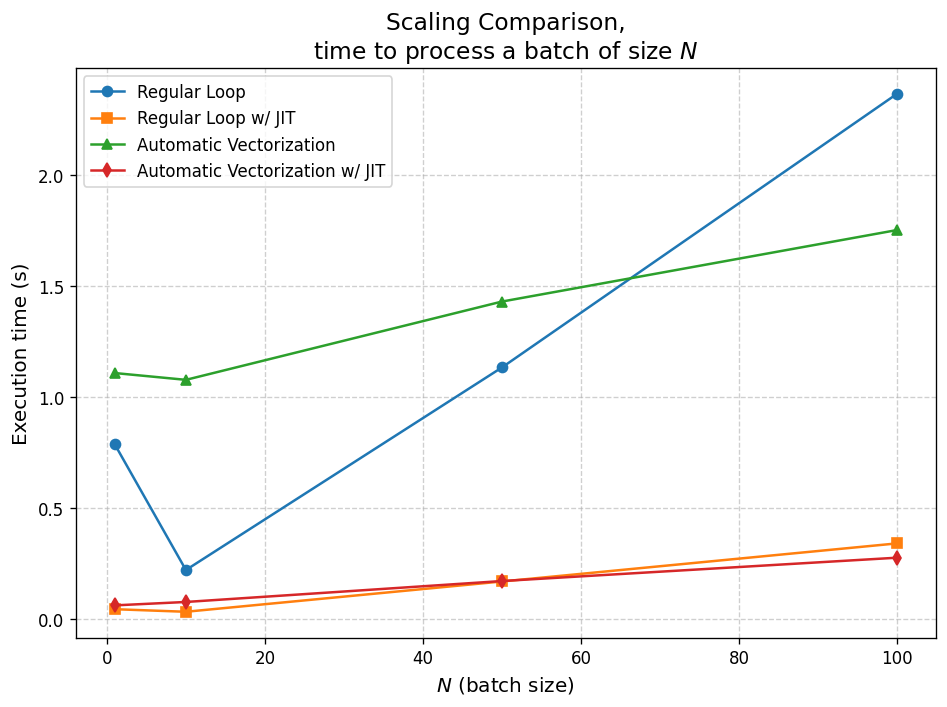

In [23]:
plt.figure(figsize=(8, 6), dpi=120)

plt.plot(batch_sizes, times_non_jit, marker="o", label="Regular Loop")
plt.plot(batch_sizes, times_jit_loop, marker="s", label="Regular Loop w/ JIT")
plt.plot(batch_sizes, times_vmap, marker="^", label="Automatic Vectorization")
plt.plot(batch_sizes, times_vmap_jit, marker="d", label="Automatic Vectorization w/ JIT")

plt.xlabel("$N$ (batch size)", fontsize=12)
plt.ylabel("Execution time (s)", fontsize=12)
plt.title("Scaling Comparison,\ntime to process a batch of size $N$", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Shots and samples

In JAX, all random number generators must be explicitly seeded. This means that when simulations include randomness, the QNode requires a `jax.random.PRNGKey`. If we want to use JIT, then we must create the QNode inside the JIT decorator's scope.

In [25]:
@jax.jit
def circuit(key, param):
    dev = qml.device("default.qubit", wires=2, shots=10, seed=key)
    @qml.qnode(dev, interface="jax", diff_method=None)
    def my_circuit():
        qml.RX(param, wires=0)
        qml.CNOT(wires=[0, 1])
        return qml.sample(qml.PauliZ(0))
    
    return my_circuit()

In [26]:
key1 = jax.random.PRNGKey(0)
key2 = jax.random.PRNGKey(1)

result1 = circuit(key1, jnp.pi/2)
result2 = circuit(key1, jnp.pi/2)
result3 = circuit(key2, jnp.pi/2)

print("Result with key1 (first call):", result1)
print("Result with key1 (second call):", result2)
print("Result with key2:", result3)

Result with key1 (first call): [ 1.  1.  1. -1.  1. -1. -1.  1. -1.  1.]
Result with key1 (second call): [ 1.  1.  1. -1.  1. -1. -1.  1. -1.  1.]
Result with key2: [ 1.  1. -1.  1. -1. -1.  1.  1.  1. -1.]
